<a href="https://colab.research.google.com/github/Farhad0111/ACCHADeepLearningApproachForIdentifyingDiseasedAndFreshCottonLeavesAndPlants/blob/main/Copy_of_AI_AGENT_MODULE_1_FAQ_CHATBOT_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAG Chatbot with LangChain, FAISS, Ollama (Gemma), and Custom Data Ingestion


# 🧠 Introduction to RAG and Context Windows

## 🔍 What is RAG?

**RAG (Retrieval-Augmented Generation)** is a technique that combines language models (like LLMs) with external knowledge sources.

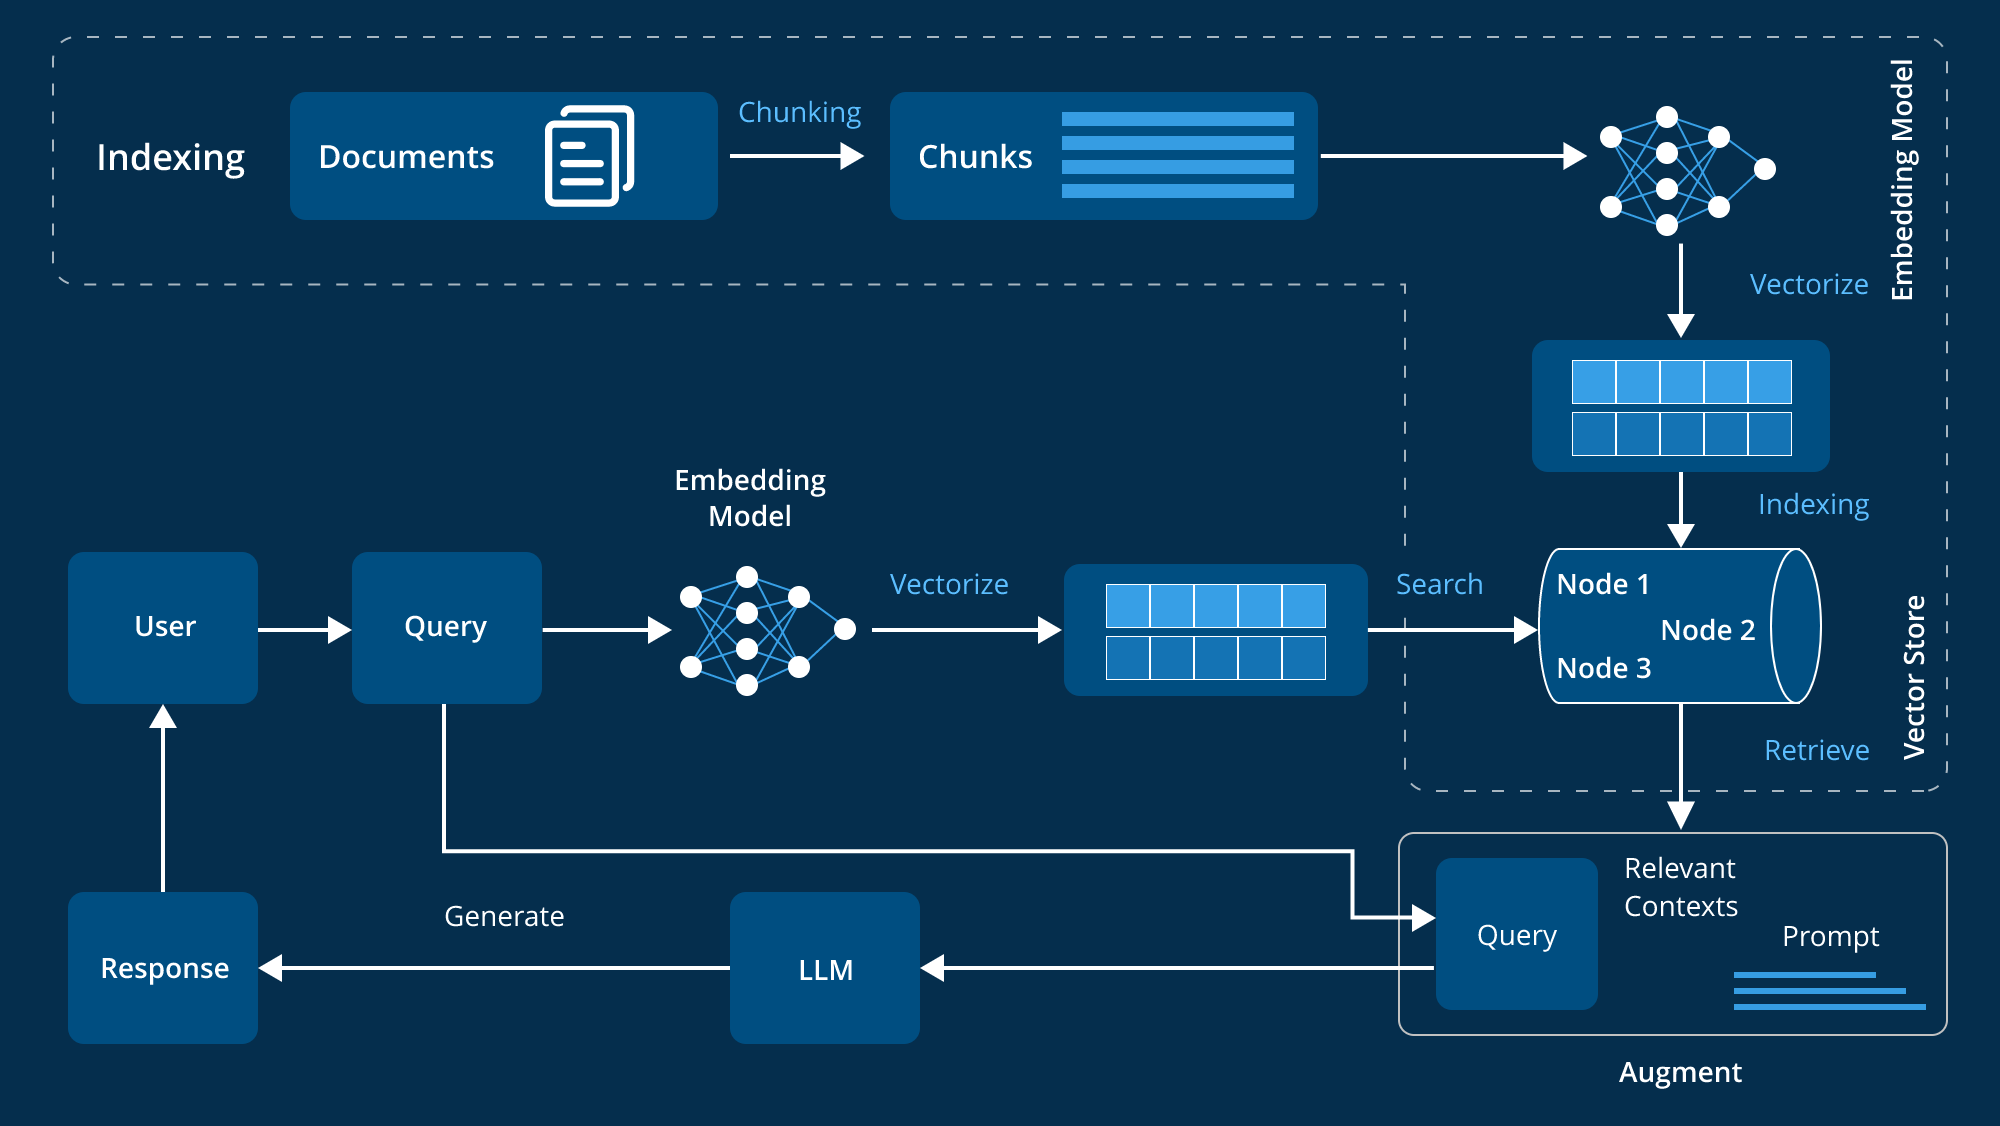

- **Problem**: LLMs have a *fixed context window* — they can only "see" a limited amount of text (e.g., 4k, 8k, 32k, 128k tokens).
- **Solution**: With RAG, instead of putting *everything* in the prompt, we use an **embedding-based retriever** to bring only the relevant content.

## 🧠 What is a Context Window?
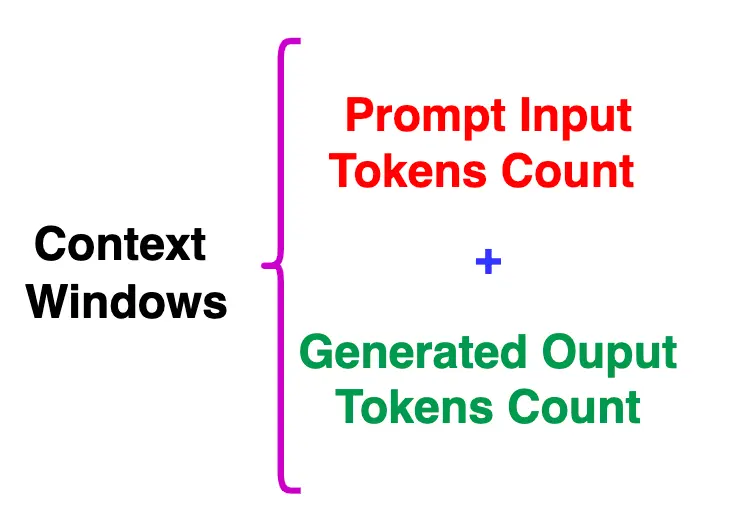
- The amount of tokens (words, punctuation, etc.) the model can process at once.
- E.g., if a model has a 4096-token limit, anything more will be truncated.

## 📦 Why Chunking?
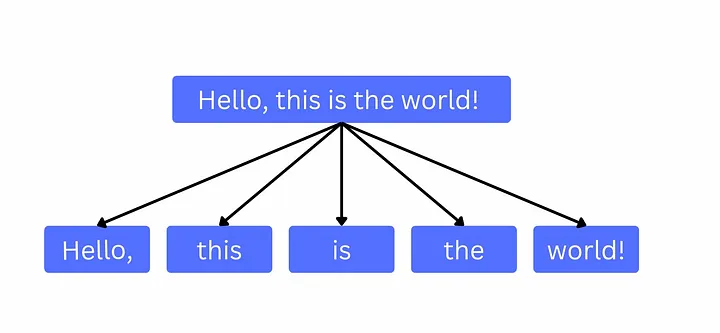
- Breaking long texts (like PDFs) into smaller chunks (e.g., 300 tokens).
- Helps in retrieving only the relevant pieces later.
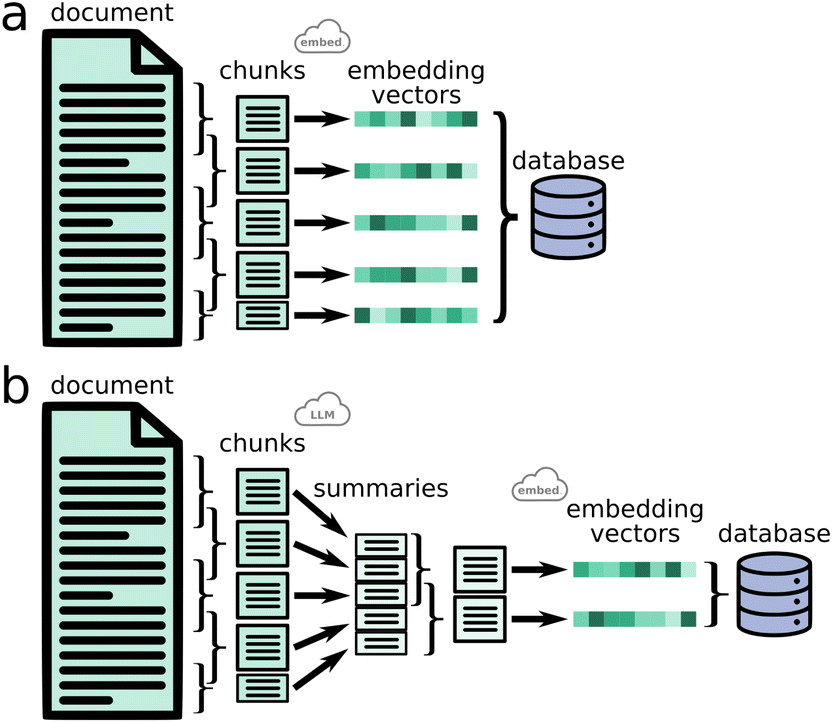



## 📚 Vector Databases vs SQL
- **SQL/NoSQL**: Great for structured data.
- **Vector DBs (like FAISS, Chroma, Weaviate)**: Built for **similarity search** on text embeddings.

Example: "What is LangChain?" → Converted to vector → Find similar chunks → Send to LLM → Get answer


In [ ]:
# Install Dependencies
!pip install -q langchain faiss-cpu pypdf langchain-community
!pip install -q sentence-transformers
!pip install -q ollama
!pip install -q langchain-ollama
!pip install -q langchain-core

In [ ]:
# Import Libraries
from langchain_community.document_loaders import PyPDFLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import Ollama
from langchain.chains import RetrievalQA
from langchain_community.document_loaders import WebBaseLoader

In [ ]:
import bs4
# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()


In [ ]:

print(f"Loaded {len(docs)} documents")


Loaded 1 documents


In [ ]:
print(docs)

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

# ✂️ Chunking the Document

In [ ]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=50
)
chunks = splitter.split_documents(docs)
print(f"Split into {len(chunks)} chunks")


Split into 61 chunks


In [ ]:
for index, i in enumerate(chunks[:2]):
  print(f"Chunk Number ",index+1)
  print(i)
  print("#####################")

Chunk Number  1
page_content='LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory'

# Download Ollama and Pull Models (Embedding Model and LLM Model)

In [ ]:
!sudo apt update
!sudo apt install -y pciutils
!curl -fsSL https://ollama.com/install.sh | sh

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,628 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,801 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,750 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,040 kB]
Hit:9 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu

In [ ]:
import threading
import subprocess
import time

def run_ollama_serve():
  subprocess.Popen(["ollama", "serve"])

thread = threading.Thread(target=run_ollama_serve)
thread.start()
time.sleep(5)

## Pull Embedding Model From Ollama

In [ ]:
!ollama pull all-minilm

# Pull LLM From Ollama

In [ ]:
!ollama pull gemma3

## Langchain Ollama LLM & Embedding

In [ ]:
from langchain_community.chat_models import ChatOllama
from langchain_community.embeddings import OllamaEmbeddings

# LLM

In [ ]:
llm=ChatOllama(
    model="gemma3",
    temperature=0.5
)

/tmp/ipython-input-13-2944536766.py:1: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm=ChatOllama(


# Embedding Model

In [ ]:
embedding_model=OllamaEmbeddings(model="all-minilm")

/tmp/ipython-input-14-951086459.py:1: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  embedding_model=OllamaEmbeddings(model="all-minilm")




# 🔎 Create Embeddings and Vector Store


In [ ]:
vectorstore = FAISS.from_documents(chunks, embedding_model)
print("✅ Vectorstore created with FAISS")

✅ Vectorstore created with FAISS


In [ ]:
61 [ ][].. 61 ta ,  Query [] - >  chunk 1 , ... 5

In [ ]:
vectorstore.similarity_search("what is task decomposition",k=5)

[Document(id='1759fbdc-37c3-4fe1-b189-94e8fef5dbe1', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-f

In [ ]:
vectorstore.similarity_search("Self Reflection in AI Agent",k=5)

[Document(id='1abefcd0-c3ed-41a2-a3b4-0a1b5c240697', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Memory stream: is a long-term memory module (external database) that records a comprehensive list of agents’ experience in natural language.\n\nEach element is an observation, an event directly provided by the agent.\n- Inter-agent communication can trigger new natural language statements.\n\n\nRetrieval model: surfaces the context to inform the agent’s behavior, according to relevance, recency and importance.\n\nRecency: recent events have higher scores\nImportance: distinguish mundane from core memories. Ask LM directly.\nRelevance: based on how related it is to the current situation / query.\n\n\nReflection mechanism: synthesizes memories into higher level inferences over time and guides the agent’s future behavior. They are higher-level summaries of past events (<- note that this is a bit different from self-reflection above)'),
 Document(i

# 🔄 Build the RAG Pipeline using LangChain

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=vectorstore.as_retriever(),
    return_source_documents=True
)

# 💬 Ask Questions to Your Chatbot

In [ ]:
questions = [
    "What is an LLM-powered autonomous agent?",
    "How does the planning component work in such agents?",
    "What is an Agent",
    # "What is the Chain of Thought (CoT) technique and why is it useful?",
    # "How does Tree of Thoughts improve upon Chain of Thought?",
    # "What is LLM+P and how does it involve external planners?"
]

In [ ]:
for question in questions:
    print(f"\n❓ Question: {question}")
    result = qa_chain.invoke({"query": question})
    print("📎 Answer:", result['result'])
    print("📚 Retrieved Chunks:")
    for doc in result['source_documents']:
        print("-", doc.page_content[:150], "...\n")


❓ Question: What is an LLM-powered autonomous agent?
📎 Answer: According to the text, an LLM-powered autonomous agent is a system where a Large Language Model (LLM) acts as the “brain” of the agent. It’s built with several key components, including:

*   **Planning:** Breaking down large tasks into smaller subgoals and reflecting on past actions to improve results.
*   **Memory:** Utilizing short-term in-context learning and long-term memory through external vector stores.
*   **Tool Use:** The ability to call external APIs for information and execution.

Essentially, it’s a system designed to independently solve problems by using an LLM to guide its actions.
📚 Retrieved Chunks:
- LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large la ...

- }
]
Challenges#
After going through key ideas and demos of building LLM-centered agents, I start to see a couple common limitations: ...

- Memory

Sho


#   What is Chat History and Why it Matters?


"""
Chat history helps the LLM remember previous interactions.

Example:
    User: What is LangChain?
    Assistant: It's a Python library to connect LLMs with tools.
    User: Who created it?
    Assistant: (Uses past context to infer "it" refers to LangChain)
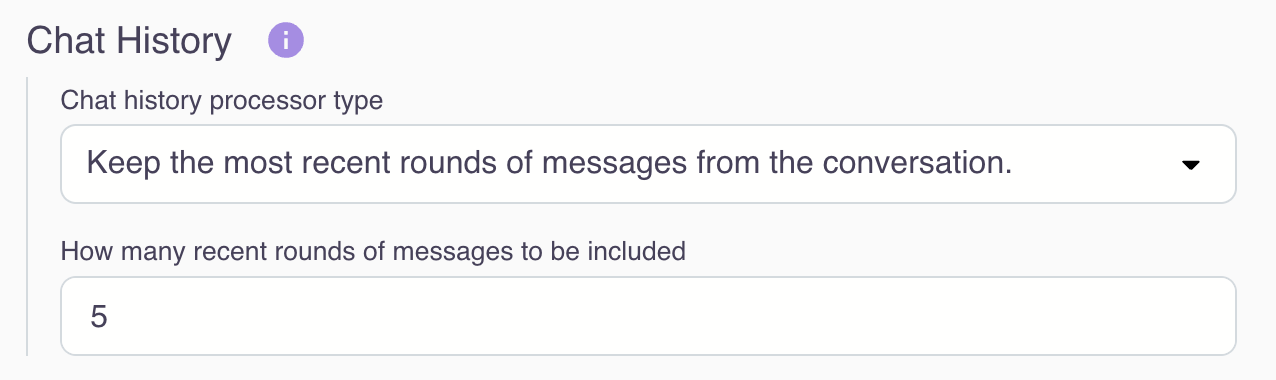


---

### 🔁 Advanced Ideas to Explore in RAG

RAG (Retrieval-Augmented Generation) is highly customizable. Here are advanced areas to explore:

- 📸 **Multimodal Inputs**: Incorporate image summarization and generate text chunks from images using vision-language models.
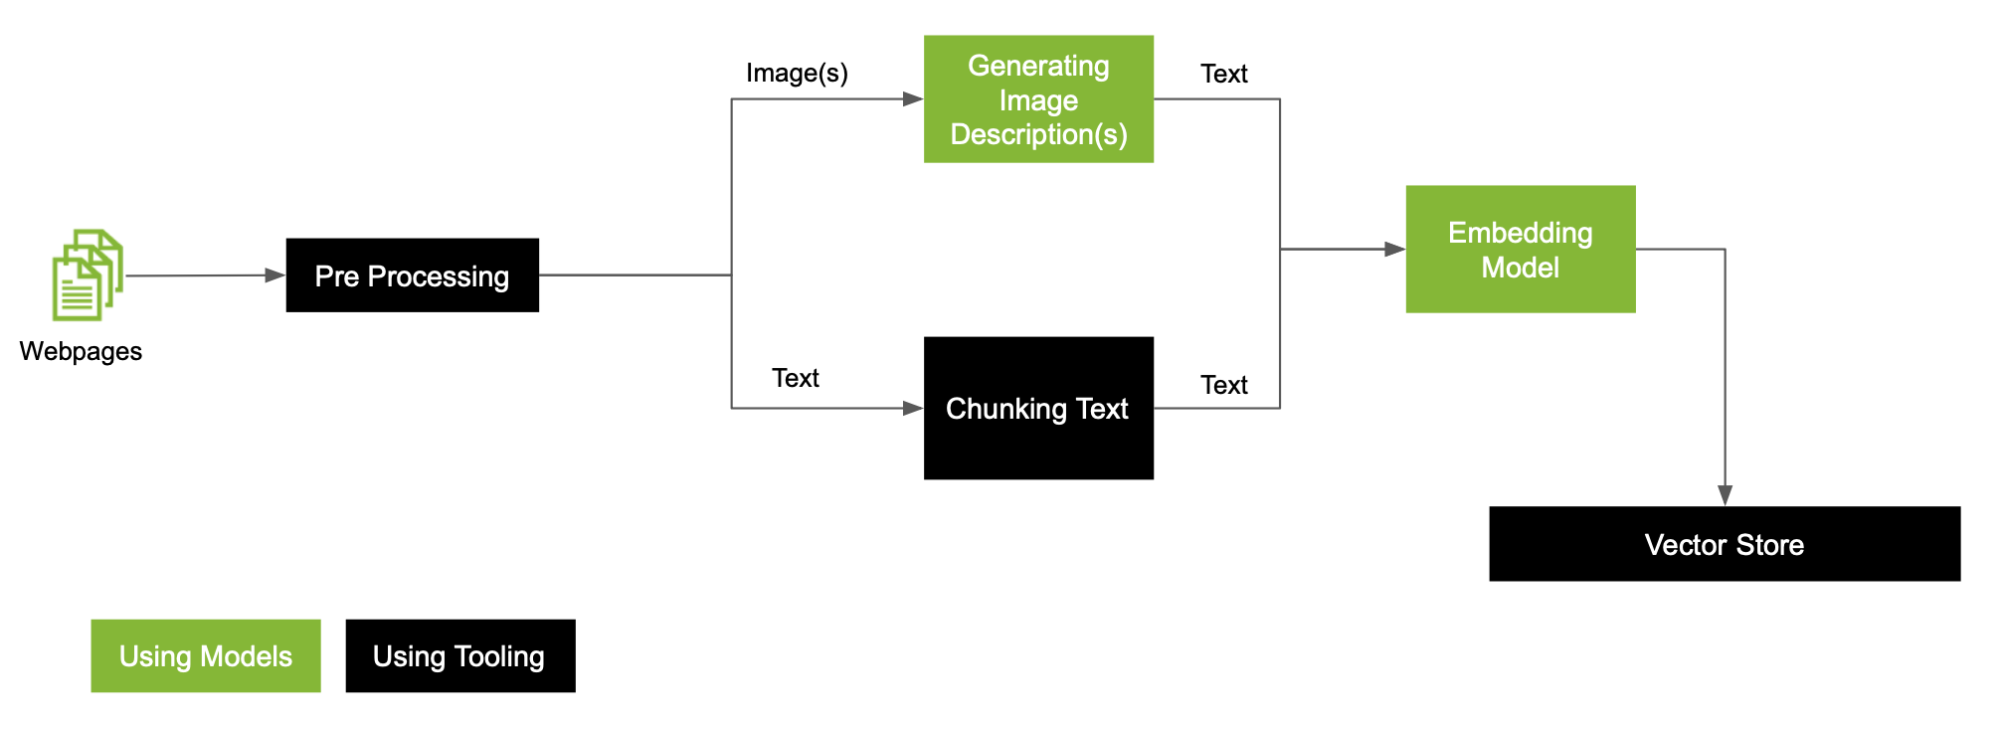
- ✂️ **Chunking Strategies**: Try different chunk sizes and overlap settings. The quality of retrieval and generation depends a lot on how well you chunk!
## Chunking Strategy
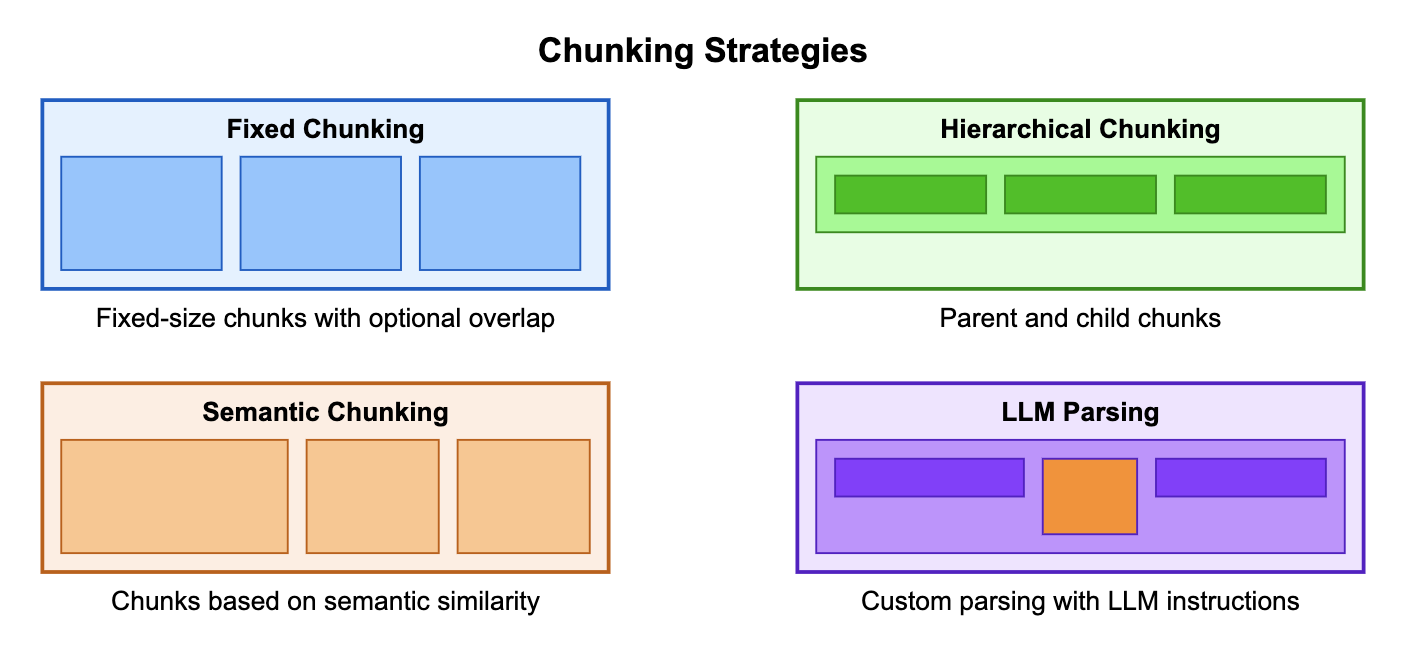
- 🔍 **Embedding Models**: Experiment with different embedding models like `all-MiniLM`, `bge`, `e5`, `instructor`, etc.
- 🧠 **LLMs**: Swap out Gemma with other Ollama-supported models like `llama3`, `mistral`, or `phi3`.
- 🥇 **Re-ranking**: Improve relevance by re-ranking retrieved chunks using models like `bge-reranker`.
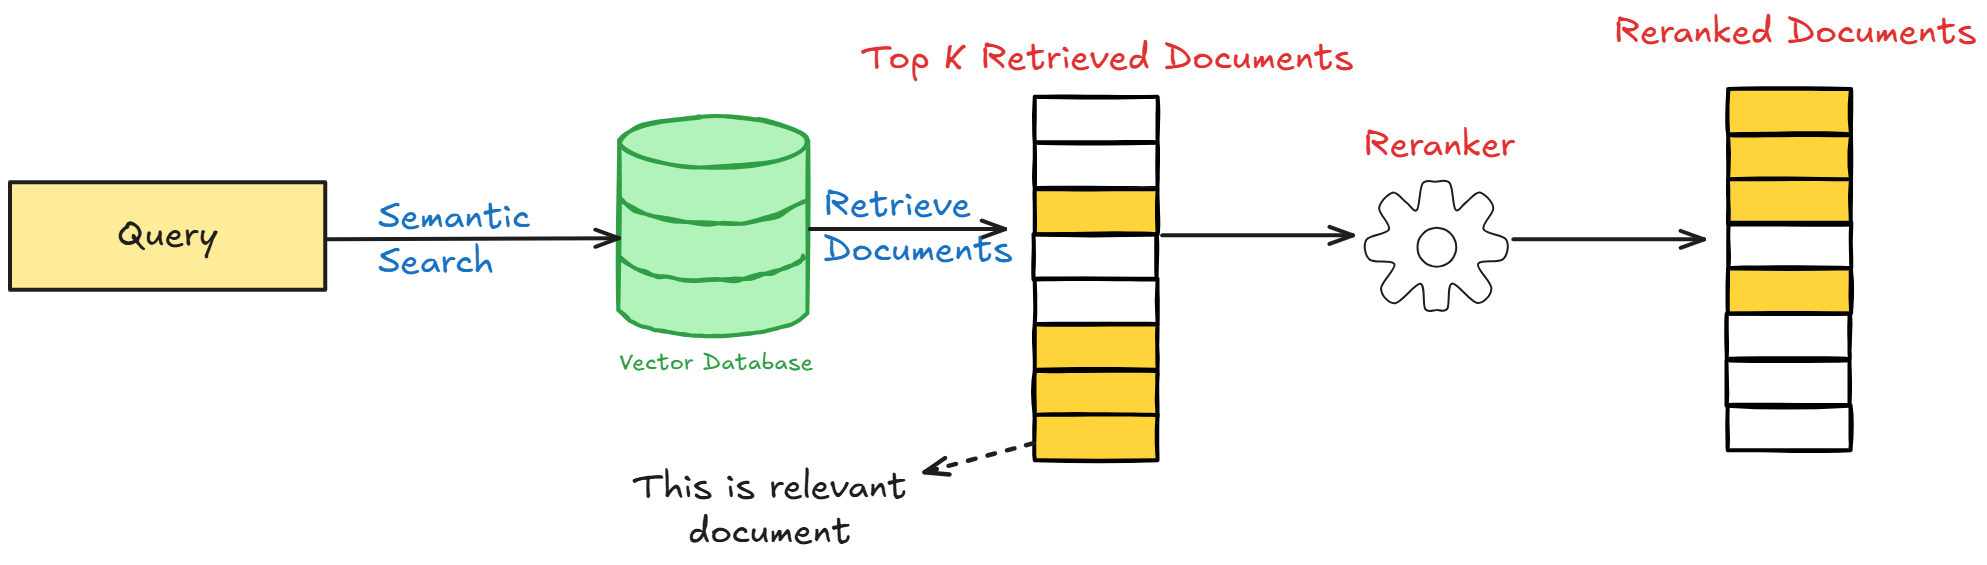
- 🧾 **Metadata Filtering**: Store metadata (e.g., page number, section name) with chunks and filter during retrieval to narrow down context.

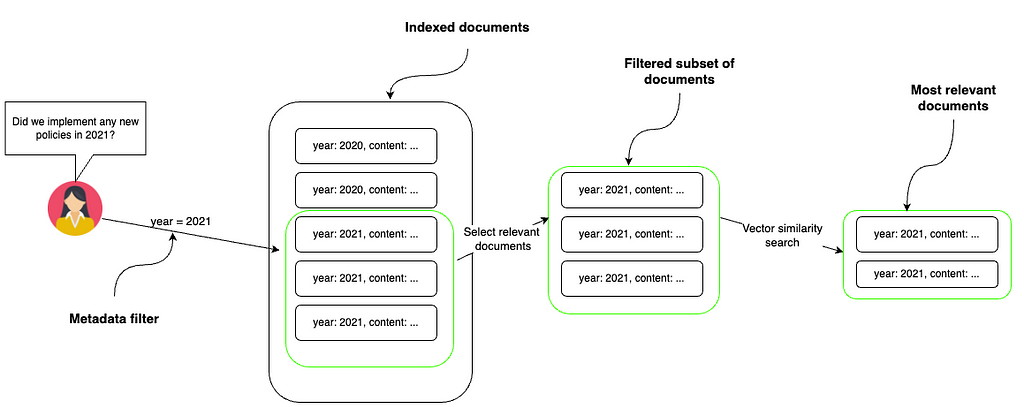


In [ ]:
print("\n✨ Demo Complete! Your first RAG-based chatbot is live!")


✨ Demo Complete! Your first RAG-based chatbot is live!
